#### Plot N versus z Distributions
This notebook demonstrates how to make number-density versus redshift plots for a set of magnitude ranges.
Features that are demonstrated:
* selection of data quantities to plot
* definition of filters to be applied to the data selection
* use of the GCRCatalogs iterator for large catalogs
* aggregation of histograms on the fly
* looping over sub-plots

In [5]:
#set up the environment
import sys
import os
import numpy as np
sys.path.insert(0, '/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages')
sys.path.insert(0, '/global/u1/k/kovacs/gcr-catalogs_v4x')
import GCRCatalogs
import math                                                                                                                                               
try:                                                                                                                                                      
    from itertools import zip_longest                                                                                                                     
except ImportError:                                                                                                                                       
    from itertools import izip_longest as zip_longest                                                                                                     
from GCR import GCRQuery
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
gc = GCRCatalogs.load_catalog('proto-dc2_v4.15_test')


/global//u1/k/kovacs/gcr-catalogs_v4x/GCRCatalogs/alphaq.py:114: UserWarning: No md5 sum specified in the config file
  warnings.warn('No md5 sum specified in the config file')


In [26]:
def get_mags_and_redshift(gc, mag_lo, mag_hi, band='r', z='redshift_true', zlo=0., zhi=1.1, 
                          nrows=3, ncolumns=2, Nzbins=20):
    #setup quantities to fetch
    possible_mag_fields = ('mag_true_{}_lsst', 'mag_true_{}_sdss', 'mag_true_{}_des')
    mag_fields = [f.format(band) for f in possible_mag_fields]
    mag_field = gc.first_available(*mag_fields)
    required_quantities = [mag_field, z]
    zbins = np.linspace(zlo, zhi, Nzbins+1)
    filters = [(lambda z: (z > zlo) & (z < zhi), z)]  #filter on selected redshift range
    
    #initialize arrays for storing histogram sums
    N_array = np.zeros((nrows, ncolumns, len(zbins)-1), dtype=np.int)
    sumz_array = np.zeros((nrows, ncolumns, len(zbins)-1))
    #get catalog data by looping over data iterator (needed for large catalogs) and aggregate histograms
    for catalog_data in gc.get_quantities(required_quantities, filters=filters, return_iterator=True):
        catalog_data = GCRQuery(*((np.isfinite, col) for col in catalog_data)).filter(catalog_data)
        for n, (cut_lo, cut_hi, N, sumz) in enumerate(zip_longest(
                mag_lo,
                mag_hi,
                N_array.reshape(-1, N_array.shape[-1]), #flatten all but last dimension of array
                sumz_array.reshape(-1, sumz_array.shape[-1]),
        )):
            if cut_lo:
                mask = (catalog_data[mag_field] < cut_lo)
                if cut_hi:
                    mask &= (catalog_data[mag_field] >= cut_hi)
                    z_this = catalog_data[z][mask]
                    
                del mask

                #bin catalog_data and accumulate subplot histograms
                N += np.histogram(z_this, bins=zbins)[0]
                sumz += np.histogram(z_this, bins=zbins, weights=z_this)[0]
        
    return zbins, N_array, sumz_array

In [34]:
#select some magnitude cuts and fill the histogram arrays for 2-column plots
mlo = 25
mhi = 19
mag_lo = [float(m) for m in range(int(mhi+1), int(mlo+1))]
mag_hi = [float(mhi) for m in range(len(mag_lo))]
ncolumns = 2
nrows = (len(mag_lo) + ncolumns - 1)//ncolumns
#print(mag_lo, mag_hi, nrows)
zbins, N_array, sumz_array = get_mags_and_redshift(gc, mag_lo, mag_hi, nrows=nrows, ncolumns=ncolumns)
#print(zbins, N_array[0, 0], sumz_array[0, 0])

In [61]:
#make plots
def plot_N_vs_z(mag_lo, mag_hi, N_array, sumz_array, zbins, band='r', normed=True,
                nrows=3, ncolumns=2, figx_p=9, figy_p=11):
    fig, ax = plt.subplots(nrows, ncolumns, figsize=(figx_p, figy_p), sharex='col')
    for n, (ax_this, cut_lo, cut_hi, N, sumz) in enumerate(zip_longest(
            ax.flat,                                                                                                                                      
            mag_lo,                                                                           
            mag_hi,                                                                           
            N_array.reshape(-1, N_array.shape[-1]),                                                
            sumz_array.reshape(-1, sumz_array.shape[-1]),                                                                                 
    )):                                                                                            
        if cut_lo is None:  #cut_lo is None if mag_lo is exhausted                            
            ax_this.set_visible(False)                                                             
        else:
            cut_label = '{} $< {}$'.format(band, cut_lo)
            if cut_hi:
                cut_label = '${} <=$ {}'.format(cut_hi, cut_label)
                meanz = sumz / N
                sumN = N.sum()
                covariance = np.diag(N)
                
                if normed:
                    scale = sumN * (zbins[1:] - zbins[:-1])
                    N = N/scale
                    covariance = covariance/np.outer(scale, scale)

                Nerrors = np.sqrt(np.diag(covariance))
                #print(meanz, N, Nerrors)
                ax_this.errorbar(meanz, N, yerr=Nerrors, label=cut_label, color='blue', fmt='o', ms=4)
                decorate_subplot(ax_this, n, nrows, ncolumns, 'p(z|m)', 'z')
    
                
def decorate_subplot(ax, nplot, nrows, ncolumns, ylabel, xlabel):
    #add axes and legend              
    if nplot % ncolumns == 0:  #1st column
        ax.set_ylabel('$'+ylabel+'$', size=16)

    if nplot+1 <= nplot - ncolumns:  #x scales for last ncol plots only
        #print "noticks",nplot                                                  
        for axlabel in ax.get_xticklabels():                                    
            axlabel.set_visible(False)                                          
            #prevent overlapping yaxis labels                                   
            ax.yaxis.get_major_ticks()[0].label1.set_visible(False)             
    else:                                                                       
        ax.set_xlabel('$'+xlabel+'$', size=16)                                   
        for axlabel in ax.get_xticklabels():                                    
            axlabel.set_visible(True)                                           
        ax.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10, numpoints=1)
         


/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide


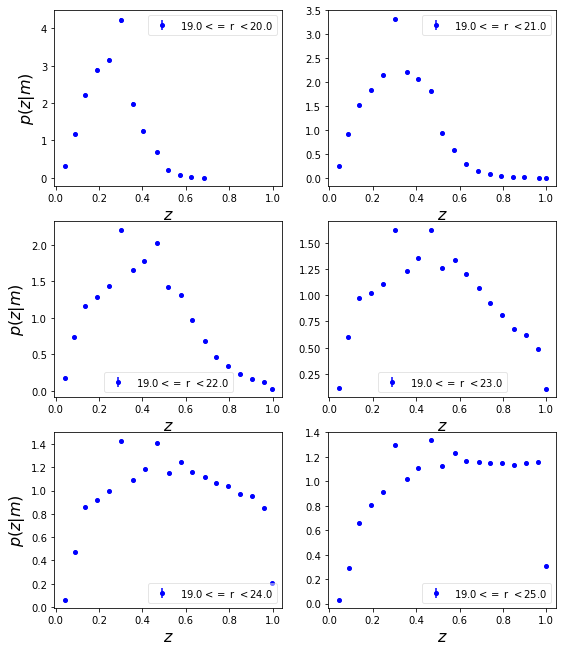

In [62]:
#call the plotting function
plot_N_vs_z(mag_lo, mag_hi, N_array, sumz_array, zbins, nrows=nrows, ncolumns=ncolumns, normed=True)
